### Gather data for PCA

In [109]:
import pandas as pd
import geopandas as gpd
import numpy as np
from rasterio import rasterio, Affine
from rasterio.warp import reproject, Resampling
from pathlib import Path
from scipy import ndimage
from scipy.misc import bytescale
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import seaborn as sns



In [2]:
#inputs local
inortho = r"T:\UAS\2018-676-FA\products\ortho\2018-10-23-Wildlands_ortho.tif"
indsm = r"T:\UAS\2018-676-FA\products\dsm\2018-10-23-Wildlands_DSM_10cm.tif"
invari = r"D:\jlogan\2018-676-FA\tmp_veg_indices\vari_scaled_int_fromlzw.tif"
intgi = r"D:\jlogan\2018-676-FA\tmp_veg_indices\tgi_scaled_int_fromlzw.tif"
inpoints = r"T:\UAS\2018-676-FA\validation\wld_topo_17-18_combined_kdthinned10cm.csv"

#inputs lab computer
#inortho = r"D:\jlogan\2018-676-FA\products\ortho\2018-10-23-Wildlands_ortho_lzw.tif"
#indsm = r"D:\jlogan\2018-676-FA\products\dsm\2018-10-23-Wildlands_DSM_10cm.tif"
#invari = r"D:\jlogan\2018-676-FA\tmp_veg_indices\vari_scaled_int_fromlzw.tif"
#intgi = r"D:\jlogan\2018-676-FA\tmp_veg_indices\tgi_scaled_int_fromlzw.tif"
#inpoints = r"T:\UAS\2018-676-FA\validation\wld_topo_17-18_combined_kdthinned10cm.csv"

for n in [inortho, indsm, invari, intgi, inpoints]:
    n = Path(n)   

In [3]:
#load input pts
ptdf = pd.read_csv(inpoints)

In [4]:
#load input rgb image
dataset = rasterio.open(inortho)
imgaff = dataset.transform
#img = dataset.read()

In [5]:
r = dataset.read(1)
g = dataset.read(2)
b = dataset.read(3)

In [6]:
#calc psuedo veg indices
#https://agribotix.com/blog/2017/04/30/comparing-rgb-based-vegetation-indices-with-ndvi-for-agricultural-drone-imagery/
tgi = g - 0.39 * r - 0.61 * b
vari = (g-r)/g+r-b

#mask infs in vari
vari_masked = np.ma.masked_invalid(vari)
tgi_masked = np.ma.masked_invalid(tgi)
del tgi, vari

#scale to 0 -255
vari_scaled = bytescale(vari_masked)
tgi_scaled = bytescale(tgi_masked)
del tgi_masked, vari_masked


C:\Users\jlogan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\jlogan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\jlogan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  if sys.path[0] == '':
C:\Users\jlogan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  del sys.path[0]


In [7]:
r.shape, vari_scaled.shape

((43008, 30720), (43008, 30720))

In [8]:
#for r, g, b, vari and tgi sample grid and add to df

#get img coords on df
ptdf['imgcol_int'], ptdf['imgrow_int'] = np.floor(~imgaff * (ptdf['e'], ptdf['n'])).astype(int)

ptdf['r'] = r[ptdf['imgrow_int'],ptdf['imgcol_int']]
ptdf['g'] = g[ptdf['imgrow_int'],ptdf['imgcol_int']]
ptdf['b'] = b[ptdf['imgrow_int'],ptdf['imgcol_int']]
ptdf['vari'] = vari_scaled[ptdf['imgrow_int'],ptdf['imgcol_int']]
ptdf['tgi'] = tgi_scaled[ptdf['imgrow_int'],ptdf['imgcol_int']]

In [9]:
#load dsm
dataset = rasterio.open(indsm)
dsmaff = dataset.transform
dsm = dataset.read()
dsm.shape

(1, 13470, 9630)

In [10]:
#resample to match input rgb image
#from https://github.com/mapbox/rasterio/blob/master/docs/topics/resampling.rst
orig_dsm_res = dsmaff.a
target_dsm_res = imgaff.a
resample_factor = orig_dsm_res / target_dsm_res

dsm_resamp = np.empty(shape=(dsm.shape[0],  # same number of bands
                         round(dsm.shape[1] * resample_factor), # new resolution
                         round(dsm.shape[2] * resample_factor)))

# adjust the new affine transform to the smaller cell size
newaff = Affine(dsmaff.a / resample_factor, dsmaff.b, dsmaff.c,
                dsmaff.d, dsmaff.e / resample_factor, dsmaff.f)

print(f'Orig. cell size: {dsmaff.a}\nTarget cell size: {imgaff.a}\nOutput cell size: {newaff.a}')

reproject(
    dsm, dsm_resamp,
    src_transform = dsmaff,
    dst_transform = newaff,
    src_crs = dataset.crs,
    dst_crs = dataset.crs,
    resampling = Resampling.bilinear)

Orig. cell size: 0.1
Target cell size: 0.03200000000003911
Output cell size: 0.03200000000003911


In [59]:
#get new pt coords for newdsm
ptdf['dsmcol_int'], ptdf['dsmrow_int'] = np.floor(~newaff * (ptdf['e'], ptdf['n'])).astype(int)

In [67]:
#Get newdsm elevation 
_,sizerow, sizecol = dsm_resamp.shape
ptdf = ptdf.loc[(ptdf['dsmrow_int'].abs() <= sizerow-1) & (ptdf['dsmcol_int'].abs() <= sizecol-1)]

ptdf['dsmelev'] = dsm_resamp[0,ptdf['dsmrow'], ptdf['dsmcol']]


In [72]:
#calc "veg ht"
ptdf['veght_est'] = ptdf['elev_m'] - ptdf['dsmelev']

In [12]:
#generic filter not working.  very slow
# #calc mean of kernel
# #from https://gis.stackexchange.com/a/254795/129277
# # use 10 cm DSM for less memory requirements 
# #(just use 1/3 * desired kernel size (eg. 96 pixel kernel on 3cm dsm would be 32 pixel kernel))
# std96 = ndimage.generic_filter(dsm, np.nanstd, size=32, mode='constant', cval=np.NaN)


In [62]:
#get elevation mean and std over 96 and 128 pixel windows
def getstat(dsmcol, dsmrow, arr, numpixels, stat='mean'):
#     intcol = np.floor(dsmcol).astype(int)
#     introw = np.floor(dsmrow).astype(int)
    intcol = dsmcol
    introw = dsmrow
    halfkernel = np.round(numpixels / 2).astype(int)
    if stat == 'mean':
        kern_stat = np.nanmean(arr[0,introw-halfkernel:introw+halfkernel, intcol-halfkernel:intcol+halfkernel])
    elif stat == 'std':
        kern_stat = np.nanstd(arr[0,introw-halfkernel:introw+halfkernel, intcol-halfkernel:intcol+halfkernel])
    return(kern_stat)

ptdf['std96'] = ptdf.apply(lambda row: getstat(row['dsmcol_int'], row['dsmrow_int'], dsm_resamp, 96, 'std'), axis=1)
ptdf['std128'] = ptdf.apply(lambda row: getstat(row['dsmcol_int'], row['dsmrow_int'], dsm_resamp, 128, 'std'), axis=1)

# def getmean(dsmcol, dsmrow, dsm, numpixels):
#     intcol = np.floor(dsmcol).astype(int)
#     introw = np.floor(dsmrow).astype(int)
#     halfkernel = numpixels / 2
#     kern_mean = np.nanmean(dsm[introw-halfkernel:introw+halfkernel, intcol-halfkernel:intcol+halfkernel])
#     return(kern_mean)

ptdf['mean96'] = ptdf.apply(lambda row: getstat(row['dsmcol_int'], row['dsmrow_int'], dsm_resamp, 96, 'mean'), axis=1)
ptdf['mean128'] = ptdf.apply(lambda row: getstat(row['dsmcol_int'], row['dsmrow_int'], dsm_resamp, 128, 'mean'), axis=1)

In [73]:
ptdf.head()

,pid,n,e,elev_m,elht_m,dt_lcl,imgcol_int,imgrow_int,r,g,...,dsmcol,dsmrow,std96,std128,mean96,mean128,dsmcol_int,dsmrow_int,dsmelev,veght_est
0,10000,4243205.453,616284.505,2.257,-29.559,10/23/2018 8:40,19797,25829,110,90,...,19797,25829,0.094232,0.108933,2.956423,2.950467,19797,25829,2.925619,-0.668619
1,10001,4243225.736,616281.420,2.228,-29.587,10/23/2018 8:41,19700,25195,123,101,...,19700,25195,0.138956,0.141158,2.698030,2.664834,19700,25195,2.568034,-0.340034
2,10002,4243355.681,616273.594,2.267,-29.545,10/23/2018 8:49,19456,21134,117,98,...,19456,21134,0.042794,0.047933,2.536494,2.525381,19456,21134,2.558038,-0.291038
3,10003,4243534.182,616376.776,1.814,-29.990,10/23/2018 9:01,22680,15556,71,60,...,22680,15556,0.169458,0.192793,3.123362,3.170680,22680,15556,2.993588,-1.179588
4,10004,4243490.071,616387.120,6.066,-25.740,10/23/2018 9:05,23003,16935,143,126,...,23003,16935,0.075430,0.086194,6.394929,6.376588,23003,16935,6.433279,-0.367279


#### PCA
based on: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60


In [74]:
#make a copy of df for PCA
pcadf = ptdf[['veght_est','dsmelev','r','g', 'b', 'vari', 'tgi', 'std96','std128','mean96','mean128']]


In [76]:
#export so no need to rerun whole nb
pcadf.to_csv(r"T:\UAS\2018-676-FA\GIS\dataforPCA.csv",index=False)

In [120]:
#standardize data
att = ['dsmelev','r','g', 'b', 'vari', 'tgi', 'std96','std128','mean96','mean128']
#separate features
x = pcadf.loc[:, att].values
#sep target
y = pcadf.loc[:, ['veght_est']].values
# Standardize  features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=3) #will choose 3 channels
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

In [122]:
outdf =  pd.DataFrame(pca.components_, columns = ['dsmelev','r','g', 'b', 'vari', 'tgi', 'std96','std128','mean96','mean128']
                   ,index = ['PC-1','PC-2','PC-3'])

outdf



,dsmelev,r,g,b,vari,tgi,std96,std128,mean96,mean128
PC-1,0.392744,0.420325,0.400391,0.335084,0.305103,0.092174,-0.002362,-0.003670,0.386729,0.381211
PC-2,0.407758,-0.378788,-0.398076,-0.399285,-0.103143,-0.023161,0.026965,0.011203,0.424264,0.424656
PC-3,0.007072,-0.000518,0.036217,0.050718,-0.094422,0.030418,0.702096,0.702282,-0.000701,-0.009297


In [107]:
pca.explained_variance_ratio_

array([0.34929971, 0.25738766, 0.19804269])

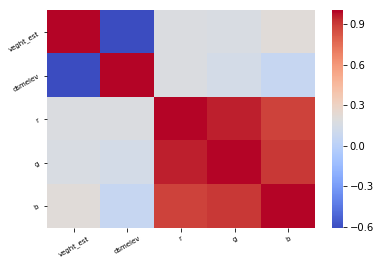

In [116]:
s=sns.heatmap(pcadf[['veght_est','dsmelev','r','g','b']].corr(),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7);
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7);

#### PCA
based on: https://stackoverflow.com/a/34692511

In [103]:
# normalize data
data_scaled = pd.DataFrame(preprocessing.scale(pcadf),columns = pcadf.columns) 

# PCA
pca = PCA(n_components=3)
pca.fit_transform(data_scaled)

outdf2 = pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2', 'PC-3'])

C:\Users\jlogan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


In [104]:
outdf2

,veght_est,dsmelev,r,g,b,vari,tgi,std96,std128,mean96,mean128
PC-1,-0.235226,0.462687,0.317360,0.297674,0.233556,0.264178,0.091678,0.013234,0.008948,0.455192,0.448403
PC-2,-0.359160,0.256202,-0.459298,-0.463880,-0.450173,-0.186156,-0.028109,0.049954,0.036919,0.262593,0.261366
PC-3,-0.039638,-0.021623,0.017667,0.056772,0.070867,-0.091418,0.034771,0.698330,0.699624,-0.031956,-0.040968


In [128]:
# corr = data_scaled[['veght_est','dsmelev','r','g','b', 'vari','tgi']].corr()
corr = data_scaled.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,veght_est,dsmelev,r,g,b,vari,tgi,std96,std128,mean96,mean128
veght_est,1,-0.61,0.18,0.17,0.22,0.0069,-0.12,-0.088,-0.076,-0.54,-0.52
dsmelev,-0.61,1,0.18,0.13,0.066,0.27,0.061,0.029,0.016,0.97,0.96
r,0.18,0.18,1,0.96,0.88,0.58,0.07,-0.026,-0.013,0.15,0.14
g,0.17,0.13,0.96,1,0.91,0.43,0.23,0.0095,0.024,0.11,0.11
b,0.22,0.066,0.88,0.91,1,0.13,-0.14,0.021,0.028,0.061,0.061
vari,0.0069,0.27,0.58,0.43,0.13,1,0.34,-0.095,-0.083,0.22,0.2
tgi,-0.12,0.061,0.07,0.23,-0.14,0.34,1,0.035,0.051,0.043,0.034
std96,-0.088,0.029,-0.026,0.0095,0.021,-0.095,0.035,1,0.96,0.021,0.01
std128,-0.076,0.016,-0.013,0.024,0.028,-0.083,0.051,0.96,1,-0.0004,-0.016
mean96,-0.54,0.97,0.15,0.11,0.061,0.22,0.043,0.021,-0.0004,1,1
